In [ ]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
!pip install catboost
import catboost as cat
from catboost import CatBoostClassifier, CatBoostClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score
import xgboost as xgb
import lightgbm as lgb
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 65.9MB 44kB/s 


In [ ]:
def one_hot_encoding(traindata, testdata, *args):
    
    for ii in args:
        traindata = pd.get_dummies(traindata, prefix=[ii], columns=[ii])
        testdata = pd.get_dummies(testdata, prefix=[ii], columns=[ii])
        
    return traindata, testdata

def drop_columns(traindata, testdata, target, *args):
    
    labels = np.array(traindata[target])
    
    columns = []
    for _ in args:
        columns.append(_)
        
    traindata = traindata.drop(columns, axis=1)
    #traindata = traindata.drop(target, axis=1)
    testdata = testdata.drop(columns, axis=1)
        
    return labels, traindata, testdata

In [ ]:
def fill_missing_values(data):
    
    '''
    Function to input missing values based on the column object type
    '''
    
    cols = list(data.columns)
    for col in cols:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        
            data[col] = data[col].fillna(data[col].mean())
        
        #elif data[col].dtype == 'O' or data[col].dtype == 'object':
        #    data[col] = data[col].fillna(data[col].mode()[0])
            
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            
    return data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

#importing files
train = pd.read_csv('/content/drive/My Drive/DSN-Churn-Prediction-Challenge/Train.csv')
test = pd.read_csv('/content/drive/My Drive/DSN-Churn-Prediction-Challenge/Test.csv')
sample = pd.read_csv('/content/drive/My Drive/DSN-Churn-Prediction-Challenge/sample_submission.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def process(traindata, testdata):
    
    cols = list(traindata.columns)
    for _ in cols:
        traindata[_] = np.where(traindata[_] == np.inf, 0, traindata[_])
        testdata[_] = np.where(testdata[_] == np.inf, 0, testdata[_])
        traindata[_] = np.where(traindata[_] == np.nan, 0, traindata[_])
        testdata[_] = np.where(testdata[_] == np.nan, 0, testdata[_])
        traindata[_] = np.where(traindata[_] == -np.inf, 0, traindata[_])
        testdata[_] = np.where(testdata[_] == -np.inf, 0, testdata[_])
        
    return traindata, testdata

In [ ]:
def freq_encode(data, cols):
    for i in cols:
        encoding = data.groupby(i).size()
        encoding = encoding/len(data)
        data[i + '_enc'] = data[i].map(encoding)
    return data

def mean_target(data, cols):
    kf = KFold(5)
    a = pd.DataFrame()
    for tr_ind, val_ind in kf.split(data):
        X_tr, X_val= data.iloc[tr_ind].copy(), data.iloc[val_ind].copy()
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col).CHURN.mean())
            X_val[col + '_mean_target'] = means + 0.0001
        a = pd.concat((a, X_val))
    prior = target.mean()
    a.fillna(prior, inplace=True)
    return a

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
target = train.CHURN.copy()
df = pd.concat((train, test)).reset_index(drop=True)

In [ ]:
train.isna().sum()

user_id                0
REGION            157520
TENURE                 0
MONTANT           140277
FREQUENCE_RECH    140277
REVENUE           134663
ARPU_SEGMENT      134663
FREQUENCE         134663
DATA_VOLUME       196854
ON_NET            145819
ORANGE            166317
TIGO              239386
ZONE1             368310
ZONE2             374487
MRG                    0
REGULARITY             0
TOP_PACK          167329
FREQ_TOP_PACK     167329
CHURN                  0
dtype: int64

In [ ]:
cols = ['user_id', 'ZONE1', 'ZONE2', 'MRG']

labels, train1, test1 = drop_columns(df, test, 'CHURN', *cols)

one_hot_cols = ['REGION', 'TENURE']

#df, test1 = one_hot_encoding(df, test, *one_hot_cols)

In [ ]:
cols = ['user_id', 'MRG']

labels, df, test1 = drop_columns(df, test, 'CHURN', *cols)

In [ ]:
df.shape, test1.shape

((500000, 17), (100000, 16))

In [ ]:
df = freq_encode(df, ['TOP_PACK', 'REGION', 'TENURE'])
data = df.copy()

In [ ]:
data.shape

(500000, 20)

In [ ]:
data.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN,TOP_PACK_enc,REGION_enc,TENURE_enc
0,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,62,All-net 500F=2000F;5d,35.0,0.0,0.147182,0.055564,0.948528
1,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,40,"Data: 100 F=40MB,24H",22.0,0.0,0.038936,NaN,0.948528
2,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,32,All-net 500F=2000F;5d,3.0,0.0,0.147182,0.025738,0.948528
3,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,18,On net 200F=Unlimited _call24H,3.0,0.0,0.071344,0.016588,0.948528
4,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,50,NaN,NaN,0.0,NaN,0.016588,0.948528


In [ ]:
data = freq_encode(data, ['REGION', 'TENURE'])
data = mean_target(data, ['REGION', 'TOP_PACK', 'TENURE'])

In [ ]:
data, test1 = one_hot_encoding(data, test, *one_hot_cols)

In [ ]:
data.head()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN,TOP_PACK_enc,REGION_enc,TENURE_enc,REGION_mean_target,TOP_PACK_mean_target,TENURE_mean_target,REGION_0.18711,REGION_DAKAR,REGION_DIOURBEL,REGION_FATICK,REGION_KAFFRINE,REGION_KAOLACK,REGION_KEDOUGOU,REGION_KOLDA,REGION_LOUGA,REGION_MATAM,REGION_SAINT-LOUIS,REGION_SEDHIOU,REGION_TAMBACOUNDA,REGION_THIES,REGION_ZIGUINCHOR,TENURE_D 3-6 month,TENURE_E 6-9 month,TENURE_F 9-12 month,TENURE_G 12-15 month,TENURE_H 15-18 month,TENURE_I 18-21 month,TENURE_J 21-24 month,TENURE_K > 24 month
0,17000.00000,32.00000,18000.0,6000.0,34.0,0.18711,97.0,355.0,6.00000,0.18711,0.18711,62,All-net 500F=2000F;5d,35.00000,0.0,0.147182,0.055564,0.948528,0.013606,0.032323,0.18319,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,4300.00000,29.00000,4427.0,1476.0,37.0,1764.00000,8.0,3.0,0.00000,0.18711,2.00000,40,"Data: 100 F=40MB,24H",22.00000,0.0,0.038936,0.187110,0.948528,0.187110,0.045531,0.18319,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1500.00000,3.00000,1500.0,500.0,3.0,0.18711,30.0,30.0,0.18711,0.18711,0.18711,32,All-net 500F=2000F;5d,3.00000,0.0,0.147182,0.025738,0.948528,0.015717,0.032323,0.18319,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,1500.00000,3.00000,2497.0,832.0,4.0,0.00000,159.0,45.0,19.00000,0.18711,0.18711,18,On net 200F=Unlimited _call24H,3.00000,0.0,0.071344,0.016588,0.948528,0.016114,0.019760,0.18319,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.18711,0.18711,498.0,166.0,3.0,1.00000,1.0,3.0,0.18711,0.18711,0.18711,50,0.18711,0.18711,0.0,0.187110,0.016588,0.948528,0.016114,0.187110,0.18319,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
len(data.TOP_PACK.unique())

113

In [ ]:
data = data.drop('TOP_PACK', axis=1)

In [ ]:
train2 = data[:ntrain].copy()
target = train2.CHURN.copy()
train2.drop('CHURN', axis=1, inplace=True)

test2 = data[ntrain:].copy()
test2.drop('CHURN', axis=1, inplace=True)
test2 = test2.reset_index(drop=True)

In [ ]:
traindata = train2.copy()
testdata = test2.copy()

In [ ]:
traindata['REG*REV'] = traindata['REGULARITY'] * traindata['REVENUE']
traindata['REG/REV'] = traindata['REGULARITY'] / traindata['REVENUE']
traindata['LOG_REV'] = np.log(traindata['REVENUE'])
traindata['REG*MUT'] = traindata['REGULARITY'] * traindata['MONTANT']
traindata['REG/MUT'] = traindata['REGULARITY'] / traindata['MONTANT']
traindata['LOG_MUT'] = np.log(traindata['MONTANT'])
traindata['REG*NET'] = traindata['REGULARITY'] * traindata['ON_NET']
traindata['REG/NET'] = traindata['REGULARITY'] / traindata['ON_NET']
traindata['FREQ+FREQ'] = traindata['FREQUENCE_RECH'] + traindata['FREQUENCE']
traindata['FREQ-FREQ'] = traindata['FREQUENCE_RECH'] - traindata['FREQUENCE']
traindata['LOG_NET'] = np.log(traindata['ON_NET'])
traindata['REV+DAT'] = traindata['REVENUE'] + traindata['DATA_VOLUME']
traindata['REV-DAT'] = traindata['REVENUE'] - traindata['DATA_VOLUME']
traindata['REV-DAT'] = traindata['REVENUE'] - traindata['DATA_VOLUME']
traindata['REV/DAT'] = traindata['REVENUE'] / traindata['DATA_VOLUME']
traindata['REV-ARP'] = traindata['REVENUE'] - traindata['ARPU_SEGMENT']
traindata['REV+ARP'] = traindata['REVENUE'] + traindata['ARPU_SEGMENT']
traindata['REV*ARP'] = traindata['REVENUE'] * traindata['ARPU_SEGMENT']
traindata['REV/ARP'] = traindata['REVENUE'] / traindata['ARPU_SEGMENT']
traindata['REV*FREQ'] = traindata['REVENUE'] * traindata['FREQUENCE']
traindata['REV/FREQ'] = traindata['REVENUE'] / traindata['FREQUENCE']
traindata['LOG_DAT'] = np.log(traindata['DATA_VOLUME'])
traindata['LOG_ARP'] = np.log(traindata['ARPU_SEGMENT'])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
traindata['REG/DAT'] = traindata['REGULARITY']/traindata['DATA_VOLUME']
traindata['REG/FREQ'] = traindata['REGULARITY']/traindata['FREQUENCE']
traindata['REG*ORANGE'] = traindata['REGULARITY']*traindata['ORANGE']
traindata['REG/ORANGE'] = traindata['REGULARITY']/traindata['ORANGE']
traindata['REG/ARP'] = traindata['REGULARITY']/traindata['ARPU_SEGMENT']
traindata['REG/FREQ-FREQ'] = traindata['REGULARITY']/traindata['FREQ-FREQ']
traindata['REG/REV+DAT'] = traindata['REGULARITY']/traindata['REV+DAT']
traindata['REG/REV-DAT'] = traindata['REGULARITY']/traindata['REV-DAT']
#traindata['ORA/REG'] = traindata['ORANGE']/traindata['REGULARITY']
#traindata['ORA/DAT'] = traindata['ORANGE']/traindata['DATA_VOLUME']
#traindata['ORA/FREQ'] = traindata['ORANGE']/traindata['FREQUENCE']
#traindata['log_ORA'] = np.log(traindata['ORANGE'])
#traindata['log_DAT'] = np.log(traindata['DATA_VOLUME'])
#traindata['DAT*REV'] = traindata['DATA_VOLUME']*traindata['REVENUE']
#traindata['DAT/REV'] = traindata['DATA_VOLUME']/traindata['REVENUE']

In [ ]:
traindata['REG*RMT'] = traindata['REGULARITY']*traindata['REGION_mean_target']
traindata['REG/RMT'] = traindata['REGULARITY']/traindata['REGION_mean_target']
traindata['RMT/REG'] = traindata['REGION_mean_target']/traindata['REGULARITY']
traindata['RMT*FREQ'] = traindata['REGION_mean_target']*traindata['FREQUENCE']
traindata['RMT/FREQ'] = traindata['REGION_mean_target']/traindata['FREQUENCE']
traindata['RMT*ORANGE'] = traindata['REGION_mean_target']*traindata['ORANGE']
traindata['RMT/ORANGE'] = traindata['REGION_mean_target']/traindata['ORANGE']

In [ ]:
#testdata.isna().sum()

In [ ]:
testdata['REG*REV'] = testdata['REGULARITY'] * testdata['REVENUE']
testdata['REG/REV'] = testdata['REGULARITY'] / testdata['REVENUE']
testdata['LOG_REV'] = np.log(testdata['REVENUE'])
testdata['REG*MUT'] = testdata['REGULARITY'] * testdata['MONTANT']
testdata['REG/MUT'] = testdata['REGULARITY'] / testdata['MONTANT']
testdata['LOG_MUT'] = np.log(testdata['MONTANT'])
testdata['REG*NET'] = testdata['REGULARITY'] * testdata['ON_NET']
testdata['REG/NET'] = testdata['REGULARITY'] / testdata['ON_NET']
testdata['FREQ+FREQ'] = testdata['FREQUENCE_RECH'] + testdata['FREQUENCE']
testdata['FREQ-FREQ'] = testdata['FREQUENCE_RECH'] - testdata['FREQUENCE']
testdata['LOG_NET'] = np.log(testdata['ON_NET'])
testdata['REV+DAT'] = testdata['REVENUE'] + testdata['DATA_VOLUME']
testdata['REV-DAT'] = testdata['REVENUE'] - testdata['DATA_VOLUME']
testdata['REV-DAT'] = testdata['REVENUE'] - testdata['DATA_VOLUME']
testdata['REV/DAT'] = testdata['REVENUE'] / testdata['DATA_VOLUME']
testdata['REV-ARP'] = testdata['REVENUE'] - testdata['ARPU_SEGMENT']
testdata['REV+ARP'] = testdata['REVENUE'] + testdata['ARPU_SEGMENT']
testdata['REV*ARP'] = testdata['REVENUE'] * testdata['ARPU_SEGMENT']
testdata['REV/ARP'] = testdata['REVENUE'] / testdata['ARPU_SEGMENT']
testdata['REV*FREQ'] = testdata['REVENUE'] * testdata['FREQUENCE']
testdata['REV/FREQ'] = testdata['REVENUE'] / testdata['FREQUENCE']
testdata['LOG_DAT'] = np.log(testdata['DATA_VOLUME'])
testdata['LOG_ARP'] = np.log(testdata['ARPU_SEGMENT'])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
testdata['REG/DAT'] = testdata['REGULARITY']/testdata['DATA_VOLUME']
testdata['REG/FREQ'] = testdata['REGULARITY']/testdata['FREQUENCE']
testdata['REG*ORANGE'] = testdata['REGULARITY']*testdata['ORANGE']
testdata['REG/ORANGE'] = testdata['REGULARITY']/testdata['ORANGE']
testdata['REG/ARP'] = testdata['REGULARITY']/testdata['ARPU_SEGMENT']
testdata['REG/FREQ-FREQ'] = testdata['REGULARITY']/testdata['FREQ-FREQ']
testdata['REG/REV+DAT'] = testdata['REGULARITY']/testdata['REV+DAT']
testdata['REG/REV-DAT'] = testdata['REGULARITY']/testdata['REV-DAT']
#testdata['ORA/REG'] = testdata['ORANGE']/testdata['REGULARITY']
#testdata['ORA/DAT'] = testdata['ORANGE']/testdata['DATA_VOLUME']
#testdata['ORA/FREQ'] = testdata['ORANGE']/testdata['FREQUENCE']
#testdata['log_ORA'] = np.log(testdata['ORANGE'])
#testdata['log_DAT'] = np.log(testdata['DATA_VOLUME'])
#testdata['DAT*REV'] = testdata['DATA_VOLUME']*testdata['REVENUE']
#testdata['DAT/REV'] = testdata['DATA_VOLUME']/testdata['REVENUE']

In [ ]:
traindata.shape, testdata.shape

((400000, 79), (100000, 72))

In [ ]:
testdata['REG*RMT'] = testdata['REGULARITY']*testdata['REGION_mean_target']
testdata['REG/RMT'] = testdata['REGULARITY']/testdata['REGION_mean_target']
testdata['RMT/REG'] = testdata['REGION_mean_target']/testdata['REGULARITY']
testdata['RMT*FREQ'] = testdata['REGION_mean_target']*testdata['FREQUENCE']
testdata['RMT/FREQ'] = testdata['REGION_mean_target']/testdata['FREQUENCE']
testdata['RMT*ORANGE'] = testdata['REGION_mean_target']*testdata['ORANGE']
testdata['RMT/ORANGE'] = testdata['REGION_mean_target']/testdata['ORANGE']

In [ ]:
traindata, testdata = process(traindata, testdata)

In [ ]:
cols = list(traindata.columns)

In [ ]:
traindata = traindata.fillna(-999)
testdata = testdata.fillna(-999)

In [ ]:
traindata.head()

In [ ]:
traindata = traindata.drop([26, 35, 18, 27, 31, 19, 20, 33, 28, 23, 32, 24], axis=1)
testdata = testdata.drop([26, 35, 18, 27, 31, 19, 20, 33, 28, 23, 32, 24], axis=1)

In [ ]:
x_train, x_test, y_train, y_test = ms.train_test_split(traindata, train.CHURN, test_size=0.2,
                                                       random_state=42, stratify=train.CHURN)

In [ ]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,21,22,25,29,30,34,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
216126,0.391165,0.622954,0.366861,0.367001,0.564404,-0.191994,2.132262,0.110848,0.183042,-0.059446,-0.063589,1.389124,0.532756,-0.580678,-1.139486,-4.259165,-0.866224,-1.105434,-0.180168,-0.129904,-0.021277,4.132686,-0.038401,-0.019239,-0.066687,-0.083779,-0.11088,6.864634,-0.076462,-4.295848,0.430843,-0.369166,0.880917,0.456090,-0.380180,0.886637,2.131959,-0.440197,0.597131,-0.057532,1.962119,0.051201,0.436012,1.377965,0.366791,0.366896,-0.062901,0.714023,-0.012782,0.157438,-0.773276,0.897199,3.029992,-0.390138,0.147183,-0.465111,-0.369575,-1.365118,-0.299489,-0.130353,-0.283961,1.844894,-0.494120,-0.177152,-0.633334,-0.113949,-0.677969
307632,-0.569322,-0.613194,-0.570852,-0.570822,-0.670829,-0.191994,-0.247156,-0.340917,-0.221958,-0.059446,-0.063589,-1.124031,-0.507302,0.985565,1.124548,0.232777,-0.790189,1.154930,-0.180168,-0.129904,-0.021277,-0.241973,-0.038401,-0.019239,-0.066687,-0.083779,-0.11088,-0.145674,-0.076462,0.232783,-0.494223,0.030777,-1.349457,-0.492393,-0.001498,-1.326418,-0.229097,-0.117693,-0.649627,0.472128,-1.052227,-0.432021,-0.208498,-0.272786,-0.570867,-0.570844,-0.186830,-1.387992,-0.316957,-0.558202,-0.773276,-1.336800,-0.366423,-0.069408,-0.304611,-0.191792,0.030006,0.485293,0.014855,-0.130810,-0.622767,-0.757908,-0.373308,-0.395465,-0.386163,-0.218178,-0.439802
297000,-0.569322,-0.613194,-0.570852,-0.570822,-0.670829,-0.191994,-0.247156,-0.340917,-0.221958,-0.059446,-0.063589,-1.168909,-0.507302,0.985565,0.483837,0.232777,1.239537,1.154930,-0.180168,-0.129904,-0.021277,-0.241973,-0.038401,-0.019239,-0.066687,-0.083779,-0.11088,-0.145674,-0.076462,0.232783,-0.494223,-0.102619,-1.349457,-0.492393,-0.127803,-1.326418,-0.229102,-0.225429,-0.649627,0.472128,-1.052227,-0.432021,-0.208498,-0.272786,-0.570867,-0.570844,-0.186830,-1.387992,-0.316957,-0.558202,-0.773276,-1.336800,-0.427073,-0.205853,-0.304631,-0.287666,-0.103433,0.485293,-0.090055,-0.130810,-0.475637,-0.844563,1.294911,-0.364720,1.744121,-0.214848,1.601029
75092,-0.569322,-0.613194,-0.414565,-0.414747,-0.537637,0.246097,-0.247156,-0.340917,-0.221958,-0.059446,-0.063589,0.222302,-0.429112,-1.166798,-1.139486,0.232777,-0.862616,-0.653893,-0.180168,-0.129904,-0.021277,4.132686,-0.038401,-0.019239,-0.066687,-0.083779,-0.11088,-0.145674,-0.076462,0.232783,-0.407975,-0.368588,0.495783,-0.492378,3.787627,-1.326418,-0.228964,3.114398,-0.578158,-0.007980,-1.052227,-0.036939,-0.520610,-0.272824,-0.414473,-0.414610,-0.183390,0.717706,-0.310992,0.456638,1.640423,0.465481,-0.548277,-0.057495,-0.304030,2.684422,-0.367837,-0.656503,-0.299610,-0.131338,-0.440759,0.623849,-0.490540,-0.372369,-0.619010,-0.218296,-0.512626
90755,-0.172444,-0.128104,-0.180403,-0.180270,0.050118,-0.138387,-0.244599,-0.244136,0.183042,-0.059446,-0.063589,-0.361109,-0.236739,0.445364,1.124548,0.232777,-0.788487,-0.935330,-0.180168,-0.129904,-0.021277,-0.241973,-0.038401,-0.019239,-0.066687,-0.083779,-0.11088,-0.145674,-0.076462,0.232783,-0.363648,-0.369211,0.692584,-0.359534,-0.380222,0.698285,-0.228162,-0.239316,-0.033624,-0.587191,-0.268018,-0.192326,0.008530,-0.272568,-0.180469,-0.180369,-0.165337,0.713287,-0.242451,-0.052206,1.130701,0.686279,-0.547899,-0.427683,-0.271552,-0.456990,-0.369712,0.171664,-0.299611,-0.130350,-0.466183,-0.234452,-0.479539,-0.205595,-0.630503,-0.185041,-0.675569


In [ ]:
x_train.shape, x_test.shape

((320000, 67), (80000, 67))

In [ ]:
cols

['ZONE1', 'ZONE2', 'user_id', 'MRG']

In [ ]:
#using StandardScaler function to scale the numeric features 

scaler = preprocessing.StandardScaler().fit(traindata)
traindata = scaler.transform(traindata)
traindata

array([[ 2.12962213,  2.04161944,  2.24281355, ..., -0.63424408,
         0.29454586, -0.67829121],
       [ 0.11332956,  1.79126678,  0.12113158, ..., -0.62316397,
        -0.15893659, -0.5362119 ],
       [-0.33120738, -0.37845629, -0.33640641, ..., -0.62273116,
        -0.16847883, -0.67718441],
       ...,
       [-0.45821794, -0.46190718, -0.46161581, ..., -0.54615743,
        -0.21484767,  1.60102942],
       [-0.56932247, -0.61319446, -0.5694741 , ..., -0.19000218,
        -0.21856681, -0.67837857],
       [-0.56932247, -0.61319446, -0.5708517 , ...,  1.74412105,
        -0.21484767,  1.60102942]])

In [ ]:
testdata = scaler.transform(testdata)
testdata

array([[-0.56932247, -0.61319446, -0.5708517 , ...,  1.74412105,
        -0.21484767,  1.60102942],
       [-0.56932247, -0.61319446, -0.56931779, ..., -0.19000218,
        -0.21484767,  1.60102942],
       [-0.26770211,  0.62295436, -0.21150964, ..., -0.61399652,
        -0.07942963, -0.61745   ],
       ...,
       [-0.28357843, -0.04465274, -0.28966782, ..., -0.58573023,
        -0.21856681, -0.67837857],
       [-0.17244419, -0.2950054 , -0.1777453 , ..., -0.6253875 ,
        -0.03288268, -0.67802397],
       [-0.56932247, -0.61319446, -0.5708517 , ..., -0.33628705,
        -0.21809958, -0.3920208 ]])

In [ ]:
traindata = pd.DataFrame(traindata)
testdata = pd.DataFrame(testdata)

In [ ]:
cols = list(traindata.columns)

In [ ]:
traindata.isna()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,REGULARITY,FREQ_TOP_PACK,TOP_PACK_enc,REGION_enc,TENURE_enc,REGION_mean_target,TOP_PACK_mean_target,TENURE_mean_target,REGION_0.18711,REGION_DAKAR,REGION_DIOURBEL,REGION_FATICK,REGION_KAFFRINE,REGION_KAOLACK,REGION_KEDOUGOU,REGION_KOLDA,REGION_LOUGA,REGION_MATAM,REGION_SAINT-LOUIS,REGION_SEDHIOU,REGION_TAMBACOUNDA,REGION_THIES,REGION_ZIGUINCHOR,TENURE_D 3-6 month,TENURE_E 6-9 month,TENURE_F 9-12 month,TENURE_G 12-15 month,TENURE_H 15-18 month,TENURE_I 18-21 month,TENURE_J 21-24 month,TENURE_K > 24 month,REG*REV,REG/REV,LOG_REV,REG*MUT,REG/MUT,LOG_MUT,REG*NET,REG/NET,FREQ+FREQ,FREQ-FREQ,LOG_NET,REV+DAT,REV-DAT,REV/DAT,REV-ARP,REV+ARP,REV*ARP,REV/ARP,REV*FREQ,REV/FREQ,LOG_DAT,LOG_ARP,REG/DAT,REG/FREQ,REG*ORANGE,REG/ORANGE,REG/ARP,REG/FREQ-FREQ,REG/REV+DAT,REG/REV-DAT
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
399996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [ ]:
'''
    After preparing your data from the above steps, model training can now happen.
    
    Using the sequential method imported from keras.model,
    a sequential Artificial Neural Network will be built
'''
#creating an instance of the sequential class
model4 = Sequential()

'''
    using model.add, we add layers to the model.
    
    Different types of layers exist, you find them all on the TensorFlow Keras documentations page
    The Dense layer is used for all layers in the model and it takes in a number of arguments.
    
    The first layer is the input layer
    and it is the only layer that takes the input_dim argument, the value should be the number of
    features/columns of data being passed into the model
    
    The model contains a total of four layers( 3 hidden layers and 1 output). The input layer is
    usually not counted as a layer
    
    args: The first parameter (number) refers to the number of neurons in that layer,
          it is also referred to as the number of outputs from that layer
          
    activation: Activation refers to the mathematical function/operation you want to 
                perform on the inputs coming into the layer before outputing it to the next layer
'''
#adding the layers to the models
model4.add(Dense(46, input_dim=67, kernel_initializer='normal', activation='relu'))
model4.add(Dense(23, activation='relu'))
model4.add(Dense(6, activation='relu'))
model4.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

'''
    model.compile is used to 'compile' the model for training, by cobining all layers together
    with the selected optimizer and loss metric to be used for training
    
    The Adam optimizer is used, other optimizer like SGD (Stochastic Gradient Descent) 
    occurs too but quite situable for specific tasks
'''

model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=2)

In [ ]:
kf = StratifiedKFold(n_splits=5,shuffle=False)
lgbm= model4
#lgbm = lgb.LGBMClassifier(num_leaves=32, learning_rate=0.01, reg_alpha=2, n_estimators=50000, subsample=1, subsample_freq=1, colsample_bytree=0.5, random_state=42)
#lgbm = CatBoostClassifier(n_estimators=50000, random_state=42, learning_rate=0.033,use_best_model=True, task_type='GPU',eval_metric='Logloss')
scores = []
pred_test = np.zeros((len(test1), 2))
for (train_index,test_index) in kf.split(pd.DataFrame(traindata),target):
    X_train,X_test = pd.DataFrame(traindata).iloc[train_index], pd.DataFrame(traindata).iloc[test_index]
    y_train,y_test = train.CHURN.iloc[train_index],train.CHURN.iloc[test_index]
    lgbm.fit(X_train, y_train, batch_size=40, validation_data = [(X_test,y_test)], callbacks=[callback], epochs=2000, shuffle=True, verbose=2)
    #lgbm.fit(X_train,y_train,early_stopping_rounds=200,eval_set=[(X_test,y_test)])
    #scores.append(metric(lgbm.predict_proba(X_test),y_test))
    pred_test+=lgbm.predict_proba(testdata)

Epoch 1/2000


ValueError: ignored

In [ ]:
cat = CatBoostClassifier(n_estimators=300, max_depth=6, task_type='GPU')
a = Model(cat, traindata, testdata, 'CHURN', 0.3)

In [ ]:
a

Learning rate set to 0.073999
0:	learn: 0.5816001	test: 0.5817912	best: 0.5817912 (0)	total: 16.1ms	remaining: 4.83s
1:	learn: 0.5031093	test: 0.5035099	best: 0.5035099 (1)	total: 31.2ms	remaining: 4.64s
2:	learn: 0.4403653	test: 0.4408782	best: 0.4408782 (2)	total: 46.7ms	remaining: 4.62s
3:	learn: 0.3949926	test: 0.3956538	best: 0.3956538 (3)	total: 61.9ms	remaining: 4.58s
4:	learn: 0.3623900	test: 0.3632315	best: 0.3632315 (4)	total: 77.1ms	remaining: 4.55s
5:	learn: 0.3385672	test: 0.3396049	best: 0.3396049 (5)	total: 97.3ms	remaining: 4.76s
6:	learn: 0.3210560	test: 0.3222500	best: 0.3222500 (6)	total: 115ms	remaining: 4.81s
7:	learn: 0.3076039	test: 0.3089503	best: 0.3089503 (7)	total: 130ms	remaining: 4.75s
8:	learn: 0.2973352	test: 0.2988261	best: 0.2988261 (8)	total: 146ms	remaining: 4.71s
9:	learn: 0.2882112	test: 0.2898394	best: 0.2898394 (9)	total: 161ms	remaining: 4.67s
10:	learn: 0.2821088	test: 0.2838878	best: 0.2838878 (10)	total: 176ms	remaining: 4.63s
11:	learn: 0.276

ValueError: ignored

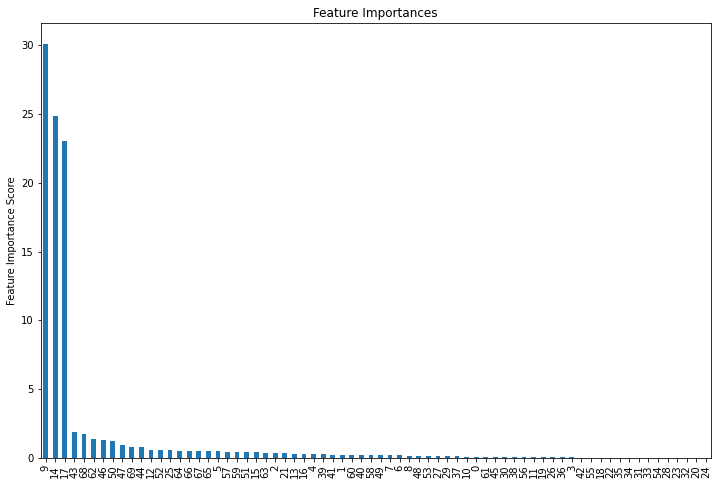

In [ ]:
a.evaluate(5, 10)

In [ ]:
pred

array([[0.21607791, 0.78392209],
       [0.38767837, 0.61232163],
       [0.86223757, 0.13776243],
       ...,
       [0.95457881, 0.04542119],
       [0.99106855, 0.00893145],
       [0.95429655, 0.04570345]])

In [ ]:
!pip install catboost==0.7.2

     |████████████████████████████████| 33.4MB 1.2MB/s 
  Found existing installation: catboost 0.24
    Uninstalling catboost-0.24:
      Successfully uninstalled catboost-0.24


In [ ]:
kf = StratifiedKFold(n_splits=20,shuffle=False)
#lgbm = lgb.LGBMClassifier(num_leaves=32, learning_rate=0.01, reg_alpha=2, n_estimators=50000, subsample=1, subsample_freq=1, colsample_bytree=0.5, random_state=42)
lgbm = CatBoostClassifier(n_estimators=50000, max_depth=6, reg_lambda=10, random_state=11, learning_rate=0.033,use_best_model=True, task_type='GPU',eval_metric='Logloss')
scores = []
pred_test = np.zeros((len(test1), 2))
for (train_index,test_index) in kf.split(pd.DataFrame(traindata),target):
    X_train,X_test = pd.DataFrame(traindata).iloc[train_index], pd.DataFrame(traindata).iloc[test_index]
    y_train,y_test = train.CHURN.iloc[train_index],train.CHURN.iloc[test_index]
    lgbm.fit(X_train,y_train,early_stopping_rounds=200,eval_set=[(X_test,y_test)])
    #scores.append(metric(lgbm.predict_proba(X_test),y_test))
    pred_test+=lgbm.predict_proba(testdata)

Streaming output truncated to the last 5000 lines.
658:	learn: 0.2496755	test: 0.2482082	best: 0.2482065 (656)	total: 12.7s	remaining: 15m 54s
659:	learn: 0.2496694	test: 0.2482065	best: 0.2482065 (656)	total: 12.8s	remaining: 15m 54s
660:	learn: 0.2496645	test: 0.2482045	best: 0.2482045 (660)	total: 12.8s	remaining: 15m 53s
661:	learn: 0.2496602	test: 0.2482069	best: 0.2482045 (660)	total: 12.8s	remaining: 15m 53s
662:	learn: 0.2496567	test: 0.2482109	best: 0.2482045 (660)	total: 12.8s	remaining: 15m 53s
663:	learn: 0.2496529	test: 0.2482077	best: 0.2482045 (660)	total: 12.8s	remaining: 15m 53s
664:	learn: 0.2496516	test: 0.2482064	best: 0.2482045 (660)	total: 12.9s	remaining: 15m 53s
665:	learn: 0.2496461	test: 0.2482048	best: 0.2482045 (660)	total: 12.9s	remaining: 15m 53s
666:	learn: 0.2496430	test: 0.2482072	best: 0.2482045 (660)	total: 12.9s	remaining: 15m 53s
667:	learn: 0.2496387	test: 0.2482066	best: 0.2482045 (660)	total: 12.9s	remaining: 15m 53s
668:	learn: 0.2496336	test: 0

In [ ]:
avg = (pred_test[:,1])/20
avg

array([0.78390875, 0.61158168, 0.12855401, ..., 0.03160917, 0.00905969,
       0.05702009])

In [ ]:
#preparing the predictions make into the sample file for submission

#preds1 = xg.predict_proba(test1)
sample1 = pd.read_csv('/content/drive/My Drive/DSN-Churn-Prediction-Challenge/sample_submission.csv')
test = pd.read_csv('/content/drive/My Drive/DSN-Churn-Prediction-Challenge/Test.csv')
sample1.user_id = test.user_id
sample1.CHURN = avg
sample1.to_csv('/content/drive/My Drive/DSN-Churn-Prediction-Challenge/SEED-11-CAT-20-FOLD-69-features.csv', index = False)

In [ ]:
#preparing the predictions make into the sample file for submission

#preds1 = xg.predict_proba(test1)
sample1 = pd.read_csv('/content/drive/My Drive/DSN-Churn-Prediction-Challenge/sample_submission.csv')
test = pd.read_csv('/content/drive/My Drive/DSN-Churn-Prediction-Challenge/Test.csv')
sample1.user_id = test.user_id
sample1.CHURN = avg
sample1.to_csv('/content/drive/My Drive/DSN-Churn-Prediction-Challenge/CAT-20-FOLD-50-features.csv', index = False)

In [ ]:
x_train.shape, x_test.shape

((320000, 70), (80000, 70))

Text(0, 0.5, 'Feature Importance Score')

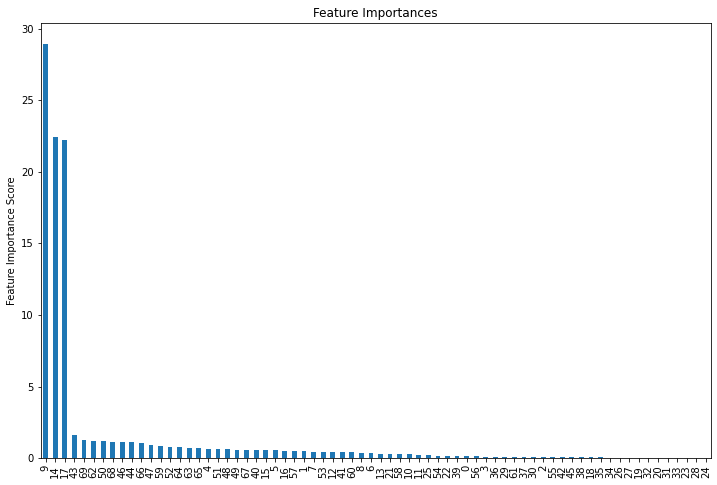

In [ ]:
feat_imp = pd.Series(lgbm.feature_importances_).sort_values(ascending=False)
plt.figure(figsize=(12,8))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Text(0, 0.5, 'Feature Importance Score')

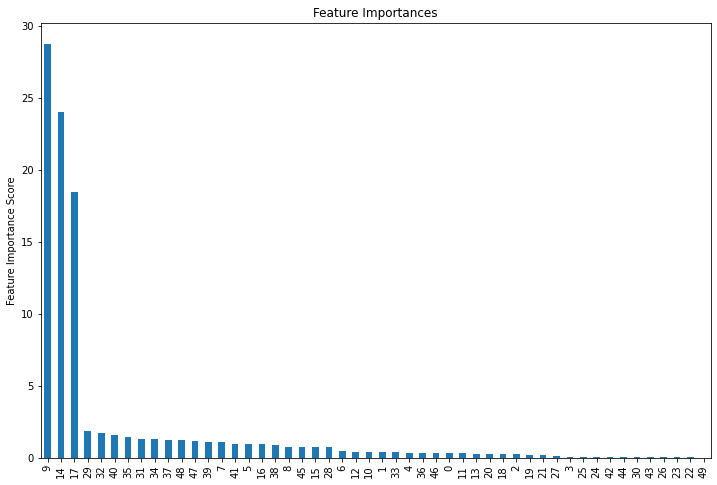

In [ ]:
feat_imp = pd.Series(lgbm.feature_importances_).sort_values(ascending=False)
plt.figure(figsize=(12,8))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Text(0, 0.5, 'Feature Importance Score')

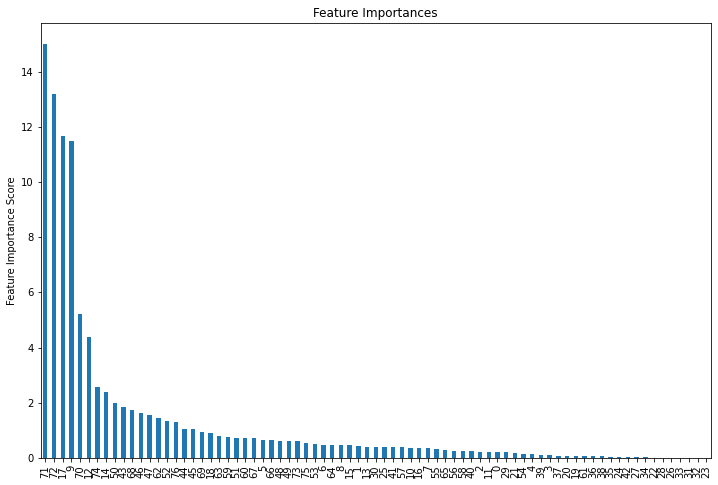

In [ ]:
feat_imp = pd.Series(lgbm.feature_importances_).sort_values(ascending=False)
plt.figure(figsize=(12,8))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Text(0, 0.5, 'Feature Importance Score')

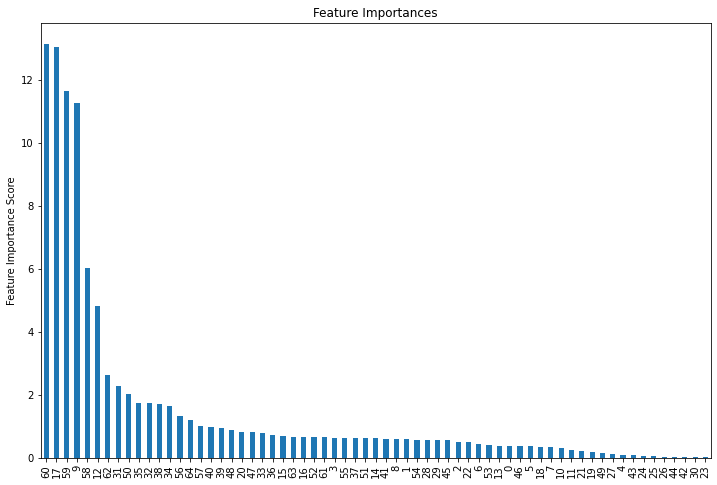

In [ ]:
feat_imp = pd.Series(lgbm.feature_importances_).sort_values(ascending=False)
plt.figure(figsize=(12,8))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
for i, j in enumerate(cols):
  print(i, j)

0 MONTANT
1 FREQUENCE_RECH
2 REVENUE
3 ARPU_SEGMENT
4 FREQUENCE
5 DATA_VOLUME
6 ON_NET
7 ORANGE
8 TIGO
9 REGULARITY
10 FREQ_TOP_PACK
11 TOP_PACK_enc
12 REGION_enc
13 TENURE_enc
14 REGION_mean_target
15 TOP_PACK_mean_target
16 TENURE_mean_target
17 REGION_0.18711
18 REGION_DAKAR
19 REGION_DIOURBEL
20 REGION_FATICK
21 REGION_KAFFRINE
22 REGION_KAOLACK
23 REGION_KEDOUGOU
24 REGION_KOLDA
25 REGION_LOUGA
26 REGION_MATAM
27 REGION_SAINT-LOUIS
28 REGION_SEDHIOU
29 REGION_TAMBACOUNDA
30 REGION_THIES
31 REGION_ZIGUINCHOR
32 TENURE_D 3-6 month
33 TENURE_E 6-9 month
34 TENURE_F 9-12 month
35 TENURE_G 12-15 month
36 TENURE_H 15-18 month
37 TENURE_I 18-21 month
38 TENURE_J 21-24 month
39 TENURE_K > 24 month
40 REG*REV
41 REG/REV
42 LOG_REV
43 REG*MUT
44 REG/MUT
45 LOG_MUT
46 REG*NET
47 REG/NET
48 FREQ+FREQ
49 FREQ-FREQ
50 LOG_NET
51 REV+DAT
52 REV-DAT
53 REV/DAT
54 REV-ARP
55 REV+ARP
56 REV*ARP
57 REV/ARP
58 REV*FREQ
59 REV/FREQ
60 LOG_DAT
61 LOG_ARP
62 REG/DAT
63 REG/FREQ
64 REG*ORANGE
65 REG/ORAN

In [ ]:
for i, j in enumerate(list(traindata.columns)):
  print(i, j)

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 21
19 22
20 25
21 29
22 30
23 34
24 36
25 37
26 38
27 39
28 40
29 41
30 42
31 43
32 44
33 45
34 46
35 47
36 48
37 49
38 50
39 51
40 52
41 53
42 54
43 55
44 56
45 57
46 58
47 59
48 60
49 61


In [ ]:
traindata.describe()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,REGULARITY,FREQ_TOP_PACK,TOP_PACK_enc,REGION_enc,TENURE_enc,REGION_mean_target,TOP_PACK_mean_target,TENURE_mean_target,REGION_0.18711,REGION_DAKAR,REGION_DIOURBEL,REGION_FATICK,REGION_KAFFRINE,REGION_KAOLACK,REGION_KEDOUGOU,REGION_KOLDA,REGION_LOUGA,REGION_MATAM,REGION_SAINT-LOUIS,REGION_SEDHIOU,REGION_TAMBACOUNDA,REGION_THIES,REGION_ZIGUINCHOR,TENURE_D 3-6 month,TENURE_E 6-9 month,TENURE_F 9-12 month,TENURE_G 12-15 month,TENURE_H 15-18 month,TENURE_I 18-21 month,TENURE_J 21-24 month,TENURE_K > 24 month,REG*REV,REG/REV,LOG_REV,REG*MUT,REG/MUT,LOG_MUT,REG*NET,REG/NET,FREQ+FREQ,FREQ-FREQ,LOG_NET,REV+DAT,REV-DAT,REV/DAT,REV-ARP,REV+ARP,REV*ARP,REV/ARP,REV*FREQ,REV/FREQ,LOG_DAT,LOG_ARP,REG/DAT,REG/FREQ,REG*ORANGE,REG/ORANGE,REG/ARP,REG/FREQ-FREQ,REG/REV+DAT,REG/REV-DAT
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,4.000000e+05,400000.000000,400000.000000,4.000000e+05,400000.000000,400000.000000,4.000000e+05,4.000000e+05,400000.000000,400000.000000,4.000000e+05,4.000000e+05,400000.000000,4.000000e+05,400000.000000,400000.000000,4.000000e+05,4.000000e+05,4.000000e+05,400000.000000,4.000000e+05,4.000000e+05,4.000000e+05,400000.000000,400000.000000,4.000000e+05,4.000000e+05,4.000000e+05,400000.000000,4.000000e+05
mean,3586.172336,7.535078,3652.087004,1217.407694,9.317837,1711.476993,175.400730,55.888851,9.401334,28.046502,5.461237,0.114264,0.147902,0.900455,0.084803,0.101586,0.187208,0.393800,0.238792,0.031440,0.016595,0.020452,0.045105,0.000452,0.018010,0.046282,0.013137,0.055313,0.001473,0.025683,0.083435,0.010030,0.000370,0.000897,0.004428,0.006970,0.012145,0.020780,0.005812,0.948597,1.890957e+05,14.800300,4.601437,1.853062e+05,16.096751,4.547625,9.658369e+03,inf,16.852915,-1.782759,-inf,5.363564e+03,1940.610011,inf,2434.679310,4869.494699,1.808765e+07,inf,1.062686e+05,275.469768,-inf,-inf,inf,18.752029,2943.854016,inf,inf,inf,7.638294,inf
std,6298.696969,11.983111,6397.291006,2132.403742,13.611117,8913.257272,708.919067,163.388126,41.513372,22.282773,10.396447,0.073913,0.081035,0.206521,0.082536,0.074052,0.019524,0.488592,0.426346,0.174504,0.127748,0.141542,0.207535,0.021267,0.132988,0.210097,0.113864,0.228589,0.038345,0.158187,0.276539,0.099646,0.019232,0.029945,0.066392,0.083195,0.109533,0.142647,0.076018,0.220818,3.826115e+05,40.064612,4.651875,3.763377e+05,42.314175,4.692104,4.215595e+04,NaN,25.366446,3.776016,NaN,1.241419e+04,9307.566686,NaN,4264.887282,8529.694739,9.681368e+07,NaN,3.352782e+05,491.703963,NaN,NaN,NaN,39.169360,9662.465045,NaN,NaN,NaN,25.471656,NaN
min,0.187110,0.187110,0.187110,0.000000,0.187110,0.000000,0.000000,0.000000,0.000000,1.000000,0.187110,0.000002,0.000446,0.000386,0.005527,0.000100,0.099199,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.871100e-01,0.000034,-1.676059,1.871100e-01,0.000010,-1.676059,0.000000e+00,4.757374e-04,0.374220,-90.000000,-inf,1.871100e-01,-853876.000000,2.597635e-07,0.000000,0.374220,0.000000e+00,1.000000e+00,3.501015e-02,1.000000,-inf,-inf,8.081396e-06,0.038462,0.000000,2.898551e-03,1.016984e-04,-7.627108e+01,0.000008,-7.627108e+01
25%,0.187110,0.187110,0.187110,0.187110,0.187110,0.187110,0.187110,0.187110,0.187110,6.000000,0.187110,0.031718,0.055564,0.948528,0.017007,0.032737,0.182962,0.000000,0.000000,0.000000,0.000000,0

In [ ]:
xg = CatBoostClassifier(task_type='GPU',eval_metric='Logloss')

params = {'n_estimators': [3000],
          'learning_rate': [0.01, 0.033, 0.05],
          'max_depth': [7,8,9,10],
          'reg_lambda': [0,1,10,20,30]}

eval_set = [(x_test, y_test)]
clf = GridSearchCV(xg, params)
clf.fit(x_train, y_train, eval_set=eval_set, verbose=2, early_stopping_rounds = 50)

Streaming output truncated to the last 5000 lines.
146:	learn: 0.2457787	test: 0.2557030	best: 0.2556816 (130)	total: 3.19s	remaining: 1m 1s
148:	learn: 0.2457238	test: 0.2557120	best: 0.2556816 (130)	total: 3.23s	remaining: 1m 1s
150:	learn: 0.2456400	test: 0.2556984	best: 0.2556816 (130)	total: 3.27s	remaining: 1m 1s
152:	learn: 0.2455087	test: 0.2556965	best: 0.2556816 (130)	total: 3.32s	remaining: 1m 1s
154:	learn: 0.2454551	test: 0.2556959	best: 0.2556816 (130)	total: 3.36s	remaining: 1m 1s
156:	learn: 0.2453796	test: 0.2556924	best: 0.2556816 (130)	total: 3.4s	remaining: 1m 1s
158:	learn: 0.2453078	test: 0.2556909	best: 0.2556816 (130)	total: 3.44s	remaining: 1m 1s
160:	learn: 0.2452312	test: 0.2556981	best: 0.2556816 (130)	total: 3.49s	remaining: 1m 1s
162:	learn: 0.2451393	test: 0.2556969	best: 0.2556816 (130)	total: 3.53s	remaining: 1m 1s
164:	learn: 0.2450563	test: 0.2556971	best: 0.2556816 (130)	total: 3.58s	remaining: 1m 1s
166:	learn: 0.2449744	test: 0.2556802	best: 0.2556

GridSearchCV(cv=None, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f6a352d6ef0>,
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.033, 0.05],
                         'max_depth': [7, 8, 9, 10], 'n_estimators': [3000],
                         'reg_lambda': [0, 1, 10, 20, 30]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
clf.best_params_

{'learning_rate': 0.05, 'n_estimators': 300}

In [ ]:
clf.best_params_

{'learning_rate': 0.033, 'max_depth': 8, 'n_estimators': 300}

In [ ]:
clf.best_params_

{'learning_rate': 0.033,
 'max_depth': 10,
 'n_estimators': 3000,
 'reg_lambda': 10}